In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from scipy import signal
import lightgbm as lgb

Output hidden; open in https://colab.research.google.com to view.

In this Dataset, collected data in machining experiments are given. Machining data was collected from a CNC machine for variations of tool condition, feed rate, and clamping pressure.

a)feed rate
relative velocity of the cutting tool along the workpiece (mm/s)

b)clamping pressure
pressure used to hold the workpiece in the vise (bar)

In 18 machining experiments, time series data was collected with a sampling rate of 100 ms from the 4 motors in the CNC (X, Y, Z axes and spindle).
And output of each experiments includes tool condition (unworn and worn tools) and whether or not the tool passed visual inspection.
We can enjoy this dataset for tool wear detection or detection of inadequate clamping.

In [ ]:
#Mounting drive on COLAB NOTEBOOK This whole project is online, so mounting google drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
experiment_result = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CNC_data/train.csv")
print(f'train.csv : {experiment_result.shape}')
experiment_result.head(30)

train.csv : (18, 7)


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN
5,6,wax,6,4.0,worn,yes,no
6,7,wax,20,4.0,worn,no,NaN
7,8,wax,20,4.0,worn,yes,no
8,9,wax,15,4.0,worn,yes,no
9,10,wax,12,4.0,worn,yes,no


In [ ]:
experiment_tmp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CNC_data/experiment_1.csv")
print(f'experiment_X.csv : {experiment_tmp.shape}')
print(experiment_tmp.columns)
experiment_tmp.head(3)

experiment_X.csv : (1055, 48)
Index(['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.0,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.0,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.5,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep


# Pre-processing

NaN in passed_visual_inspection in experiment result means machining_finalized is no, which means machining process was not finished correctly and did not proceed to visual inspection process. So, we need to fill NaN with no.

In [ ]:
experiment_result['passed_visual_inspection'] = experiment_result['passed_visual_inspection'].fillna('no')

Adding each experiment settings and result to experiment time series data to make one total dataframe

In [ ]:
frames = []
for i in range(1,19):
    #load files
    exp_num =  str(i) if i < 10 else str(i)
    frame = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/CNC_data/experiment_{exp_num}.csv")

    #load each experiment result row
    exp_result_row = experiment_result[experiment_result['No'] == i]
    frame['exp_num'] = i

    #add experiment settings to features
    frame['material'] = exp_result_row.iloc[0]['material']
    frame['feedrate'] = exp_result_row.iloc[0]['feedrate']
    frame['clamp_pressure'] = exp_result_row.iloc[0]['clamp_pressure']
    
    #add experiment result to features
    frame['tool_condition'] = exp_result_row.iloc[0]['tool_condition']
    frame['machining_finalized'] = exp_result_row.iloc[0]['machining_finalized']
    frame['passed_visual_inspection'] = exp_result_row.iloc[0]['passed_visual_inspection']

    frames.append(frame)

df = pd.concat(frames, ignore_index = True)
# MAking a copy of df for deep learning tasks.
df_dl = df
df.head(100)

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,exp_num,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.000,0.00,198.0,0.0,0.000000,0.180,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.00,0.001,0.250,-361.00,0.0,0.000000e+00,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,1,wax,6,4.0,unworn,yes,yes
1,198.0,-10.800,-350.00,198.0,-13.6,-358.000000,-10.900,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.00,0.000,0.250,-361.00,0.0,0.000000e+00,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
2,196.0,-17.800,-6.25,196.0,-17.9,-0.000095,-8.590,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.00,0.000,-0.438,-361.00,0.0,0.000000e+00,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
3,194.0,-18.000,0.00,194.0,-17.9,-0.000095,-6.110,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.00,-0.001,-0.250,-361.00,0.0,0.000000e+00,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
4,193.0,-17.900,-18.80,192.0,-17.9,0.000095,-5.700,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.00,0.000,-0.188,-361.00,0.0,0.000000e+00,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,159.0,-0.125,-62.50,159.0,0.0,0.000000,2.750,0.0531,326.0,5.49,-0.000007,81.2,5.970,6.25,81.3,6.0,0.000000,5.070,0.0921,324.0,13.90,1.190000e-03,29.5,0.0,0.00,29.5,0.0,0.000000,0.0,0.0,0.0,0.0,-25.40,53.300,2.750,-25.00,53.3,-9.540000e-07,18.200,8.490000e-01,320.0,120.0,1.630000e-01,12.0,1.0,21.0,6.0,Layer 1 Up,1,wax,6,4.0,unworn,yes,yes
96,159.0,0.175,81.20,159.0,0.0,0.000000,0.975,0.0428,326.0,3.35,0.000006,81.8,6.070,-37.50,81.9,6.0,0.000000,4.760,0.0766,324.0,12.90,9.070000e-04,29.5,0.0,0.00,29.5,0.0,0.000000,0.0,0.0,0.0,0.0,-20.30,53.200,-55.000,-19.80,53.3,0.000000e+00,27.800,1.180000e+00,322.0,116.0,2.270000e-01,12.0,1.0,21.0,6.0,Layer 1 Up,1,wax,6,4.0,unworn,yes,yes
97,159.0,0.000,-12.50,159.0,0.0,0.000000,1.640,0.0353,325.0,5.96,-0.000015,82.7,6.030,31.30,82.7,6.0,0.000000,9.260,0.1450,324.0,14.20,1.820000e-03,29.5,0.0,0.00,29.5,0.0,0.000000,0.0,0.0,0.0,0.0,-12.60,53.300,3.440,-12.20,53.3,0.000000e+00,21.200,8.230000e-01,322.0,120.0,1.570000e-01,12.0,1.0,2.0,6.0,Layer 1 Up,1,wax,6,

# Deep-learning Preprocessing

Count of 'Starting' and 'end' label in Machining_Process column is relatevely small.
So we need to normalize these outlier labels into alternative label.
Starting -> Prep
end -> End

In [ ]:
df['Machining_Process'].value_counts().sort_index()

End              2585
Layer 1 Down     2655
Layer 1 Up       4085
Layer 2 Down     2528
Layer 2 Up       3104
Layer 3 Down     2354
Layer 3 Up       2794
Prep             1795
Repositioning    3377
Starting            1
end                 8
Name: Machining_Process, dtype: int64

In [ ]:
#Changing the data so layers can understand
df_dl['tool_condition'].replace({"unworn": "1", "worn": "0"}, inplace=True)
df_dl['machining_finalized'].replace({"yes": "1", "no": "0"}, inplace=True)
df_dl['passed_visual_inspection'].replace({"yes": "1", "no": "0"}, inplace=True)
df_dl = df_dl.drop(['Machining_Process','material','exp_num'], axis=1)
print(df_dl.shape)

(25286, 52)


In [ ]:
df_ut = df_dl
df_ut = df_ut.drop(['feedrate','clamp_pressure'], axis=1)
df_ut

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.00,0.00,198.0,0.00,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.00,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.000,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,1,1,1
1,198.0,-10.80,-350.00,198.0,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.60,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.300,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.000000e+00,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,1,1,1
2,196.0,-17.80,-6.25,196.0,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.30,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.700,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,1,1,1
3,194.0,-18.00,0.00,194.0,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.30,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.700,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.000000e+00,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,1,1,1
4,193.0,-17.90,-18.80,192.0,-17.90,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.30,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.600,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.000000e+00,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,144.0,-2.30,100.00,144.0,-2.57,0.977000,-5.05,0.0732,327.0,9.56,0.000366,73.7,1.450,-25.00,73.7,1.55,1.620000,4.680,0.0633,326.0,7.49,1.860000e-04,28.7,0.000,-6.25,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-72.4,53.300,-63.600,-72.0,53.3,0.000000e+00,20.000,8.260000e-01,323.0,118.0,1.580000e-01,12.0,1.0,57.0,3.0,0,1,1
25282,144.0,-2.47,25.00,144.0,-2.46,1.080000,-5.62,0.0996,327.0,10.30,0.000506,73.8,1.700,-12.50,73.9,1.71,1.550000,5.360,0.0787,326.0,8.17,2.620000e-04,28.7,0.000,-6.25,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-67.1,53.400,41.200,-66.6,53.3,9.540000e-07,18.800,9.710000e-01,320.0,119.0,1.870000e-01,12.0,1.0,57.0,3.0,0,1,1
25283,143.0,-2.20,81.20,143.0,-2.35,1.170000,-4.42,0.0539,327.0,7.79,0.000215,74.0,1.770,-12.50,74.0,1.86,1.480000,7.570,0.1110,326.0,7.67,4.040000e-04,28.7,0.000,0.00,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-61.7,53.300,-22.300,-61.3,53.3,-9.540000e-07,24.400,9.500000e-01,322.0,119.0,1.820000e-01,12.0,1.0,57.0,3.0,0,1,1
25284,143.0,-2.05,68.70,143.0,-2.23,1.260000,-5.83,0.0809,327.0,8.32,0.000330,74.2,1.980,0.00,74.2,2.01,1.410000,7.540,0.1250,326.0,10.60,5.400000e-04,28.7,-0.025,-6.25,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-56.4,53.200,-64.400,-56.0,53.3,0.000000e+00,21.600,9.590000e-01,3

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

!pip install eli5
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

**CASE 1: Training with all 3 parameters together.**

In [ ]:
#reading the data (training)
def read_dataset():
 X = df_ut[df_ut.columns[0:47]]
 Y = df_ut[df_ut.columns[47:]]
 return (X, Y)
# Read the dataset

X, Y = read_dataset()
#Shuffle the dataset
X, Y = shuffle(X, Y, random_state=125)
# Convert the data set into train and test part
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(X)
print(Y)

(20228, 47)
(20228, 3)
(5058, 47)
       X1_ActualPosition  ...  M1_CURRENT_FEEDRATE
16657              153.0  ...                  3.0
4438               198.0  ...                 50.0
23351              162.0  ...                  3.0
23133              162.0  ...                  3.0
24871              158.0  ...                  3.0
...                  ...  ...                  ...
5375               198.0  ...                 50.0
20311              198.0  ...                 50.0
21730              151.0  ...                 50.0
10397              141.0  ...                 50.0
19389              145.0  ...                  6.0

[25286 rows x 47 columns]
      tool_condition machining_finalized passed_visual_inspection
16657              0                   1                        1
4438               1                   0                        0
23351              0                   1                        1
23133              0                   1                       

In [ ]:
def model():
    # Define model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='tanh'))
    model.add(Dense(94, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    model.add(Dense(3, activation='tanh'))
    # Compile model    
    model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=model, batch_size=75, epochs=70, verbose=1)
history1_f = estimator.fit(train_x, train_y, verbose = 1)

n_features = train_x.shape[1]
# define model
model = Sequential()
model.add(Dense(47, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(94, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(32, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(3, activation='tanh'))
# compile the model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
history1 = model.fit(train_x, train_y, epochs=70, batch_size=75, verbose=1)
# evaluate the model
loss1, acc1 = model.evaluate(test_x, test_y, verbose=1)
print('Test Accuracy: %.3f' % acc1)

Train on 20228 samples
Epoch 1/70
20228/20228 [==============================] - 0s 17us/sample - loss: 3.6356 - acc: 0.4363
Epoch 2/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.9085 - acc: 0.4636
Epoch 3/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.8707 - acc: 0.4637
Epoch 4/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.8373 - acc: 0.5647
Epoch 5/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.8074 - acc: 0.7398
Epoch 6/70
20228/20228 [==============================] - 0s 18us/sample - loss: 2.7694 - acc: 0.7468
Epoch 7/70
20228/20228 [==============================] - 0s 18us/sample - loss: 2.7258 - acc: 0.7542
Epoch 8/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.7081 - acc: 0.7526
Epoch 9/70
20228/20228 [==============================] - 0s 17us/sample - loss: 2.6871 - acc: 0.7589
Epoch 10/70
20228/20228 [==============================] - 

In [ ]:
# Showing Weights importance (Feature importance table)
perm = PermutationImportance(estimator, random_state=1).fit(train_x,train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

Weight,Feature
0.4185 ± 0.0262,S1_CommandPosition
0.4132 ± 0.0179,S1_ActualPosition
0.0958 ± 0.0045,Y1_CommandPosition
0.0711 ± 0.0037,S1_OutputVoltage
0.0701 ± 0.0044,Z1_CommandPosition
0.0468 ± 0.0065,Z1_ActualPosition
0.0369 ± 0.0016,S1_ActualVelocity
0.0238 ± 0.0026,X1_ActualAcceleration
0.0222 ± 0.0048,M1_CURRENT_FEEDRATE
0.0185 ± 0.0023,M1_sequence_number


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_1_df_ut.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_1_df_ut.h5')

# Show the model architecture
new_model.summary()

test_prediction = new_model.predict(test_x)
print(test_prediction)

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)
print(Predict)
prediction = new_model.predict(Predict)
print(prediction)
print(np.mean(prediction, axis=0))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_19 (Dense)             (None, 94)                4512      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                3040      
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 18        
________________

**CASE 2:TRAINING WITH 1 PARAMETER AT A TIME.**


1: Training with tool condition parameter.

In [ ]:
#reading the data (training)
def read_dataset():
 X = df_ut[df_ut.columns[0:47]]
 Y = df_ut[df_ut.columns[47:48]]
 return (X, Y)
# Read the dataset

X, Y = read_dataset()
#Shuffle the dataset
X, Y = shuffle(X, Y, random_state=125)
# Convert the data set into train and test part
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(X)
print(Y)

(20228, 47)
(20228, 1)
(5058, 47)
       X1_ActualPosition  ...  M1_CURRENT_FEEDRATE
16657              153.0  ...                  3.0
4438               198.0  ...                 50.0
23351              162.0  ...                  3.0
23133              162.0  ...                  3.0
24871              158.0  ...                  3.0
...                  ...  ...                  ...
5375               198.0  ...                 50.0
20311              198.0  ...                 50.0
21730              151.0  ...                 50.0
10397              141.0  ...                 50.0
19389              145.0  ...                  6.0

[25286 rows x 47 columns]
      tool_condition
16657              0
4438               1
23351              0
23133              0
24871              0
...              ...
5375               0
20311              0
21730              1
10397              1
19389              0

[25286 rows x 1 columns]


In [ ]:
def model():
    # Define model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='tanh'))
    model.add(Dense(94, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    # Compile model    
    model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=model, batch_size=75, epochs=70, verbose=1)
history2_1_f = estimator.fit(train_x, train_y, verbose = 1)

n_features = train_x.shape[1]
# define model
model = Sequential()
model.add(Dense(47, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(94, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(32, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(1, activation='tanh'))
# compile the model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
history2_1 = model.fit(train_x, train_y, epochs=70, batch_size=75, verbose=1)
# evaluate the model
loss2_1, acc2_1 = model.evaluate(test_x, test_y, verbose=1)
print('Test Accuracy: %.3f' % acc2_1)

Train on 20228 samples
Epoch 1/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.7764 - acc: 0.5381
Epoch 2/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.7015 - acc: 0.5717
Epoch 3/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.6858 - acc: 0.5866
Epoch 4/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.6773 - acc: 0.5874
Epoch 5/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.6729 - acc: 0.5906
Epoch 6/70
20228/20228 [==============================] - 0s 20us/sample - loss: 0.6625 - acc: 0.5963
Epoch 7/70
20228/20228 [==============================] - 0s 20us/sample - loss: 0.6536 - acc: 0.5957
Epoch 8/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.6457 - acc: 0.6049
Epoch 9/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.6396 - acc: 0.6039
Epoch 10/70
20228/20228 [==============================] - 

In [ ]:
# Showing Weights importance (Feature importance table)
perm = PermutationImportance(estimator, random_state=1).fit(train_x,train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

Weight,Feature
1.8688 ± 0.0316,S1_ActualPosition
1.8418 ± 0.0388,S1_CommandPosition
0.2073 ± 0.0134,Y1_CommandPosition
0.2040 ± 0.0135,S1_OutputVoltage
0.1988 ± 0.0140,S1_ActualVelocity
0.1486 ± 0.0088,X1_ActualAcceleration
0.0956 ± 0.0089,S1_CommandVelocity
0.0883 ± 0.0096,Y1_ActualPosition
0.0875 ± 0.0134,S1_ActualAcceleration
0.0792 ± 0.0041,Z1_CommandPosition


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_1.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_1.h5')

# Show the model architecture
new_model.summary()

test_prediction = new_model.predict(test_x)
print(test_prediction)

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)
print(Predict)
prediction = new_model.predict(Predict)
print(prediction)
print(np.mean(prediction, axis=0))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_31 (Dense)             (None, 94)                4512      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                3040      
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 3         
Total params: 10,093
Trainable params: 10,093
Non-trainable params: 0
__________________________________________________

2: Training with Machining finalised parameter.

In [ ]:
#reading the data (training)
def read_dataset():
 X = df_ut[df_ut.columns[0:47]]
 Y = df_ut[df_ut.columns[48:49]]
 return (X, Y)
# Read the dataset

X, Y = read_dataset()
#Shuffle the dataset
X, Y = shuffle(X, Y, random_state=125)
# Convert the data set into train and test part
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(X)
print(Y)

(20228, 47)
(20228, 1)
(5058, 47)
       X1_ActualPosition  ...  M1_CURRENT_FEEDRATE
16657              153.0  ...                  3.0
4438               198.0  ...                 50.0
23351              162.0  ...                  3.0
23133              162.0  ...                  3.0
24871              158.0  ...                  3.0
...                  ...  ...                  ...
5375               198.0  ...                 50.0
20311              198.0  ...                 50.0
21730              151.0  ...                 50.0
10397              141.0  ...                 50.0
19389              145.0  ...                  6.0

[25286 rows x 47 columns]
      machining_finalized
16657                   1
4438                    0
23351                   1
23133                   1
24871                   1
...                   ...
5375                    1
20311                   0
21730                   1
10397                   1
19389                   1

[25286 rows x 

In [ ]:
def model():
    # Define model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='tanh'))
    model.add(Dense(94, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    # Compile model    
    model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=model, batch_size=75, epochs=70, verbose=1)
history2_2_f = estimator.fit(train_x, train_y, verbose = 1)

n_features = train_x.shape[1]
# define model
model = Sequential()
model.add(Dense(47, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(94, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(32, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(1, activation='tanh'))
# compile the model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
history2_2 = model.fit(train_x, train_y, epochs=70, batch_size=75, verbose=1)
# evaluate the model
loss2_2, acc2_2 = model.evaluate(test_x, test_y, verbose=1)
print('Test Accuracy: %.3f' % acc2_2)

Train on 20228 samples
Epoch 1/70
20228/20228 [==============================] - 0s 20us/sample - loss: 0.2482 - acc: 0.9312
Epoch 2/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.1951 - acc: 0.9460
Epoch 3/70
20228/20228 [==============================] - 0s 20us/sample - loss: 0.1899 - acc: 0.9363
Epoch 4/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.1756 - acc: 0.9446
Epoch 5/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.1668 - acc: 0.9571
Epoch 6/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.1654 - acc: 0.9576
Epoch 7/70
20228/20228 [==============================] - 0s 19us/sample - loss: 0.1572 - acc: 0.9582
Epoch 8/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.1543 - acc: 0.9604
Epoch 9/70
20228/20228 [==============================] - 0s 18us/sample - loss: 0.1541 - acc: 0.9589
Epoch 10/70
20228/20228 [==============================] - 

In [ ]:
# Showing Weights importance (Feature importance table)
perm = PermutationImportance(estimator, random_state=1).fit(train_x,train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

Weight,Feature
1.5346 ± 0.0172,S1_ActualPosition
1.4746 ± 0.0374,S1_CommandPosition
0.4612 ± 0.0166,M1_CURRENT_FEEDRATE
0.3548 ± 0.0140,S1_CurrentFeedback
0.1885 ± 0.0111,S1_OutputVoltage
0.1804 ± 0.0082,Z1_CommandPosition
0.1464 ± 0.0044,Y1_CommandPosition
0.1436 ± 0.0108,Y1_ActualAcceleration
0.1272 ± 0.0104,X1_CommandPosition
0.1185 ± 0.0062,S1_CommandVelocity


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_2.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_2.h5')

# Show the model architecture
new_model.summary()

test_prediction = new_model.predict(test_x)
print(test_prediction)

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)
print(Predict)
prediction = new_model.predict(Predict)
print(prediction)
print(np.mean(prediction, axis=0))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_43 (Dense)             (None, 94)                4512      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                3040      
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 3         
Total params: 10,093
Trainable params: 10,093
Non-trainable params: 0
__________________________________________________

3: Training with Visual inspection passed.

In [ ]:
#reading the data (training)
def read_dataset():
 X = df_ut[df_ut.columns[0:47]]
 Y = df_ut[df_ut.columns[49:50]]
 return (X, Y)
# Read the dataset

X, Y = read_dataset()
#Shuffle the dataset
X, Y = shuffle(X, Y, random_state=125)
# Convert the data set into train and test part
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(X)
print(Y)

(20228, 47)
(20228, 1)
(5058, 47)
       X1_ActualPosition  ...  M1_CURRENT_FEEDRATE
16657              153.0  ...                  3.0
4438               198.0  ...                 50.0
23351              162.0  ...                  3.0
23133              162.0  ...                  3.0
24871              158.0  ...                  3.0
...                  ...  ...                  ...
5375               198.0  ...                 50.0
20311              198.0  ...                 50.0
21730              151.0  ...                 50.0
10397              141.0  ...                 50.0
19389              145.0  ...                  6.0

[25286 rows x 47 columns]
      passed_visual_inspection
16657                        1
4438                         0
23351                        1
23133                        1
24871                        1
...                        ...
5375                         0
20311                        0
21730                        1
10397            

In [ ]:
def model():
    # Define model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='tanh'))
    model.add(Dense(94, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    # Compile model    
    model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=model, batch_size=75, epochs=70, verbose=1)
history2_2_f = estimator.fit(train_x, train_y, verbose = 1)

n_features = train_x.shape[1]
# define model
model = Sequential()
model.add(Dense(47, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(94, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(32, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(1, activation='tanh'))
# compile the model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
history2_3 = model.fit(train_x, train_y, epochs=70, batch_size=75, verbose=1)
# evaluate the model
loss2_3, acc2_3 = model.evaluate(test_x, test_y, verbose=1)
print('Test Accuracy: %.3f' % acc2_3)

Train on 20228 samples
Epoch 1/70
20228/20228 [==============================] - 0s 22us/sample - loss: 1.7013 - acc: 0.6734
Epoch 2/70
20228/20228 [==============================] - 0s 21us/sample - loss: 0.5276 - acc: 0.7739
Epoch 3/70
20228/20228 [==============================] - 0s 16us/sample - loss: 0.5053 - acc: 0.7807
Epoch 4/70
20228/20228 [==============================] - 0s 21us/sample - loss: 0.4897 - acc: 0.7941
Epoch 5/70
20228/20228 [==============================] - 0s 21us/sample - loss: 0.4772 - acc: 0.8188
Epoch 6/70
20228/20228 [==============================] - 0s 23us/sample - loss: 0.4659 - acc: 0.8300
Epoch 7/70
20228/20228 [==============================] - 0s 21us/sample - loss: 0.4646 - acc: 0.8216
Epoch 8/70
20228/20228 [==============================] - 0s 21us/sample - loss: 0.4511 - acc: 0.8355
Epoch 9/70
20228/20228 [==============================] - 0s 20us/sample - loss: 0.4442 - acc: 0.8364
Epoch 10/70
20228/20228 [==============================] - 

In [ ]:
# Showing Weights importance (Feature importance table)
perm = PermutationImportance(estimator, random_state=1).fit(train_x,train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

Weight,Feature
1.4410 ± 0.0198,S1_ActualPosition
1.2831 ± 0.0396,S1_CommandPosition
0.5985 ± 0.0127,Y1_CommandPosition
0.3774 ± 0.0159,M1_CURRENT_FEEDRATE
0.2109 ± 0.0071,S1_OutputVoltage
0.1675 ± 0.0045,S1_CommandVelocity
0.1665 ± 0.0142,X1_ActualAcceleration
0.1630 ± 0.0071,Z1_ActualPosition
0.1455 ± 0.0128,X1_ActualPosition
0.1293 ± 0.0058,S1_ActualVelocity


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_3.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_3.h5')

# Show the model architecture
new_model.summary()

test_prediction = new_model.predict(test_x)
print(test_prediction)

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)
print(Predict)
prediction = new_model.predict(Predict)
print(prediction)
print(np.mean(prediction, axis=0))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_55 (Dense)             (None, 94)                4512      
_________________________________________________________________
dense_56 (Dense)             (None, 32)                3040      
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 3         
Total params: 10,093
Trainable params: 10,093
Non-trainable params: 0
__________________________________________________

In [ ]:
#reading the data (training)
def read_dataset():
 X = df_ut[df_ut.columns[0:47]]
 Y = df_ut[df_ut.columns[48:50]]
 return (X, Y)
# Read the dataset

X, Y = read_dataset()
#Shuffle the dataset
X, Y = shuffle(X, Y, random_state=125)
# Convert the data set into train and test part
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(X)
print(Y)

(20228, 47)
(20228, 2)
(5058, 47)
       X1_ActualPosition  ...  M1_CURRENT_FEEDRATE
16657              153.0  ...                  3.0
4438               198.0  ...                 50.0
23351              162.0  ...                  3.0
23133              162.0  ...                  3.0
24871              158.0  ...                  3.0
...                  ...  ...                  ...
5375               198.0  ...                 50.0
20311              198.0  ...                 50.0
21730              151.0  ...                 50.0
10397              141.0  ...                 50.0
19389              145.0  ...                  6.0

[25286 rows x 47 columns]
      machining_finalized passed_visual_inspection
16657                   1                        1
4438                    0                        0
23351                   1                        1
23133                   1                        1
24871                   1                        1
...                  

In [ ]:
def model():
    # Define model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='tanh'))
    model.add(Dense(94, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    # Compile model    
    model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=model, batch_size=75, epochs=70, verbose=1)
history2_4_f = estimator.fit(train_x, train_y, verbose = 1)

n_features = train_x.shape[1]
# define model
model = Sequential()
model.add(Dense(47, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(94, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(32, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(8, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh', kernel_initializer='he_normal'))
model.add(Dense(2, activation='tanh'))
# compile the model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model
history2_4 = model.fit(train_x, train_y, epochs=70, batch_size=75, verbose=1)
# evaluate the model
loss2_4, acc2_4 = model.evaluate(test_x, test_y, verbose=1)
print('Test Accuracy: %.3f' % acc2_4)

Train on 20228 samples
Epoch 1/70
20228/20228 [==============================] - 0s 22us/sample - loss: 1.9059 - acc: 0.7272
Epoch 2/70
20228/20228 [==============================] - 0s 23us/sample - loss: 0.4650 - acc: 0.8331
Epoch 3/70
20228/20228 [==============================] - 0s 22us/sample - loss: 0.4330 - acc: 0.8398
Epoch 4/70
20228/20228 [==============================] - 0s 24us/sample - loss: 0.4108 - acc: 0.8600
Epoch 5/70
20228/20228 [==============================] - 0s 23us/sample - loss: 0.3976 - acc: 0.8626
Epoch 6/70
20228/20228 [==============================] - 0s 22us/sample - loss: 0.3847 - acc: 0.8644
Epoch 7/70
20228/20228 [==============================] - 1s 26us/sample - loss: 0.3719 - acc: 0.8704
Epoch 8/70
20228/20228 [==============================] - 1s 25us/sample - loss: 0.3633 - acc: 0.8717
Epoch 9/70
20228/20228 [==============================] - 1s 25us/sample - loss: 0.3535 - acc: 0.8730
Epoch 10/70
20228/20228 [==============================] - 

In [ ]:
# Showing Weights importance (Feature importance table)
perm = PermutationImportance(estimator, random_state=1).fit(train_x,train_y)
eli5.show_weights(perm, feature_names = train_x.columns.tolist())

Weight,Feature
2.5065 ± 0.0108,S1_CommandPosition
2.2921 ± 0.0368,S1_ActualPosition
0.4254 ± 0.0108,Z1_ActualPosition
0.4172 ± 0.0036,Y1_CommandPosition
0.3691 ± 0.0096,X1_CommandPosition
0.3339 ± 0.0085,Y1_ActualPosition
0.2671 ± 0.0067,M1_CURRENT_FEEDRATE
0.2549 ± 0.0111,S1_OutputVoltage
0.1947 ± 0.0089,Z1_CommandPosition
0.1117 ± 0.0066,X1_ActualPosition


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_4.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_4.h5')

# Show the model architecture
new_model.summary()

test_prediction = new_model.predict(test_x)
print(test_prediction)

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)
print(Predict)
prediction = new_model.predict(Predict)
print(prediction)
print(np.mean(prediction, axis=0))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_67 (Dense)             (None, 94)                4512      
_________________________________________________________________
dense_68 (Dense)             (None, 32)                3040      
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_71 (Dense)             (None, 2)                 6         
Total params: 10,096
Trainable params: 10,096
Non-trainable params: 0
_________________________________________________

In [ ]:
results_dl = pd.DataFrame({
    'Model': ['CASE:1', 'CASE:2_1', 'CASE:2_2', 
              'CASE:2_3','CASE:2_4'],
    'Score': [acc1, acc2_1, acc2_2, 
              acc2_3, acc2_4]})
result_df_dl = results_dl.sort_values(by='Score', ascending=False)
result_df_dl = result_df_dl.set_index('Score')
result_df_dl

,Model
Score,
0.966390,CASE:2_2
0.895710,CASE:2_4
0.834124,CASE:2_3
0.820087,CASE:1
0.671016,CASE:2_1


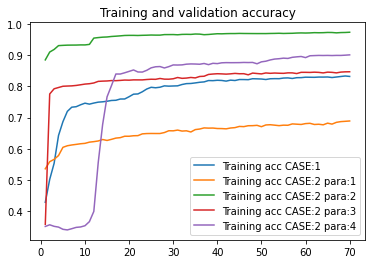

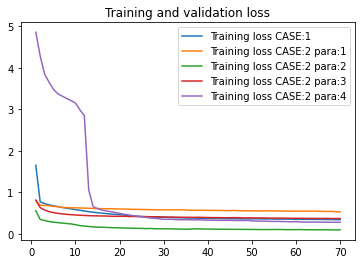

In [ ]:
acc1 = history1.history['acc']
loss1 = history1.history['loss']

acc2_1 = history2_1.history['acc']
loss2_1 = history2_1.history['loss']

acc2_2 = history2_2.history['acc']
loss2_2 = history2_2.history['loss']

acc2_3 = history2_3.history['acc']
loss2_3 = history2_3.history['loss']

acc2_4 = history2_4.history['acc']
loss2_4 = history2_4.history['loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, '-', label='Training acc CASE:1',)
plt.plot(epochs, acc2_1, '-', label='Training acc CASE:2 para:1')
plt.plot(epochs, acc2_2, '-', label='Training acc CASE:2 para:2')
plt.plot(epochs, acc2_3, '-', label='Training acc CASE:2 para:3')
plt.plot(epochs, acc2_4, '-', label='Training acc CASE:2 para:4')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, '-', label='Training loss CASE:1',)
plt.plot(epochs, loss2_1, '-', label='Training loss CASE:2 para:1')
plt.plot(epochs, loss2_2, '-', label='Training loss CASE:2 para:2')
plt.plot(epochs, loss2_3, '-', label='Training loss CASE:2 para:3')
plt.plot(epochs, loss2_4, '-', label='Training loss CASE:2 para:4')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**CODE FOR FINAL OUTPUT**
Importing the CSV File from cloud and giving prediction on that file.

In [ ]:
 # Recreate the exact same model, including its weights and the optimizer
model_tool_wear = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_1_df_ut.h5')
model_machining_1 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_2.h5')
model_machining_2 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_4.h5')
model_visual_1 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_3.h5')
model_visual_2 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Saved_models/CASE_2_df_ut_4.h5')

#The model taking input for prediction
Predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CNC_data/Predict.csv', header=None)
Predict = Predict.drop([47], axis=1)

print('The input file for prediction.')
print(Predict)
print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')


prediction = model_tool_wear.predict(Predict)
Final = np.mean(prediction, axis= 0)
if -20 < Final[0] < 0.21:
  print('Tool condition--','!!! Sevier Tool Wear !!!')
elif 0.21 < Final[0] < 0.51:
  print('Tool condition--','!! Tool Wear !!')
elif 0.51 < Final[0] < 0.61:
  print('Tool condition--','Good tool very less Wear', u'\u2713')
else:
  print('Tool condition--','Excellent tool no Wear', u'\u2713', u'\u2713')     


prediction1 = model_machining_1.predict(Predict)
prediction2 = model_machining_2.predict(Predict)
Final1 = np.mean(prediction1, axis= 0)
Final2 = np.mean(prediction2, axis= 0)

prediction3 = model_visual_1.predict(Predict)
prediction4 = model_visual_2.predict(Predict)
Final3 = np.mean(prediction3, axis= 0)
Final4 = np.mean(prediction4, axis= 0)

F1 = ((Final1+Final2[0])/2)
F2 = ((Final3+Final4[1])/2)

if -20 < F1 < 0.5 and -20 < F2 < 0.5:
  print('Final JOB--','!!! Machining not finlaised AND Visual inspection not passed  X X X X')
elif 0.5 < F1 < 10 and -20 < F2 < 0.5:
  print('Final JOB--','Machining finlaised',u'\u2713', u'\u2713','AND Visual inspection not passed X X')
elif 0.5 < F1 < 10 and 0.5 < F2 < 20:
  print('Final JOB--','Machining finlaised AND Visual inspection passed', u'\u2713', u'\u2713', u'\u2713', u'\u2713')  


print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------')
print('The overall predicted out-put for all 3 parameters in form of numeric scalar are')
print('1: Tool Wear = ', Final[0])
print('2: Machining finalised = ', F1.mean())
print('3: Visual inspection passed = ', F2.mean())

The input file for prediction.
       0      1      2      3      4   ...     42    43   44     45   46
0   162.0 -1.150  87.50  162.0 -1.340  ...  0.153  12.0  1.0    2.0  3.0
1   162.0 -1.350  87.50  162.0 -1.640  ...  0.194  12.0  1.0   86.0  3.0
2   162.0 -1.750  87.50  162.0 -1.920  ...  0.182  12.0  1.0   86.0  3.0
3   161.0 -2.130  56.30  161.0 -2.170  ...  0.145  12.0  1.0   86.0  3.0
4   161.0 -2.200  68.70  161.0 -2.390  ...  0.201  12.0  1.0   86.0  3.0
5   161.0 -2.450  18.80  161.0 -2.580  ...  0.162  12.0  1.0   86.0  3.0
6   161.0 -2.780  31.30  161.0 -2.740  ...  0.155  12.0  1.0   86.0  3.0
7   160.0 -2.830 -12.50  160.0 -2.860  ...  0.193  12.0  1.0   86.0  3.0
8   160.0 -2.750  37.50  160.0 -2.950  ...  0.175  12.0  1.0   86.0  3.0
9   160.0 -2.800  50.00  160.0 -2.990  ...  0.175  12.0  1.0   86.0  3.0
10  162.0 -0.525 -56.30  162.0 -0.467  ...  0.179  12.0  1.0    2.0  3.0
11  162.0 -0.900 -62.50  162.0 -0.803  ...  0.187  12.0  1.0  126.0  3.0
12  162.0 -1.170 -62

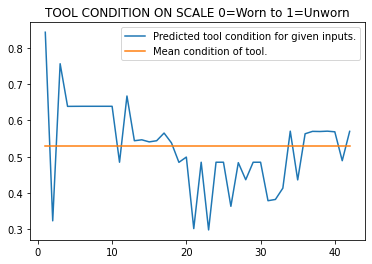

In [ ]:
xi = np.arange(1,len(prediction)+1,1)
yi_tool_state = prediction[:,0]
mi = np.full((len(prediction),),Final[0])
plt.plot(xi, yi_tool_state,'-', label='Predicted tool condition for given inputs.')
plt.plot(xi, mi,'-', label='Mean condition of tool.')
plt.title('TOOL CONDITION ON SCALE 0=Worn to 1=Unworn')
plt.legend()
plt.show()